In [75]:
import pandas as pd
from pandas import DataFrame as DF
from math import ceil
from time import time
from pandas import read_csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE

In [2]:
# run transform.R before analysing the data.
df = read_csv("Levine_32dimtransform.csv")

Non-negative matrix factorization is a dimensionality reduction technique and a clustering technique. It has been used in natural language processing, recommendation systems as well as clustering RNA-seq data.
It is used for sparse count data, which is similar to CyTOF data, as CyTOF has zeros.

![NMF](https://upload.wikimedia.org/wikipedia/commons/f/f9/NMF.png)

In the context of CyTOF data, the W matrix is the compressed form of the input matrix V which contains cell population assignments for each cell. The H matrix is a matrix showing the paremeters found on each cell type.

In [3]:
dc = NMF(n_components=15)

Using the default parameters. In subsequent analysis regularization would be useful to enforce sparsity in the hidden representations (W).

In [4]:
markers = list(df)[4:36]

In [26]:
df[markers].describe()

,Time,Cell_length,DNA1,DNA2,CD45RA,CD133,CD19,CD22,CD11b,CD4,...,HLA-DR,CD64,CD41,Viability,file_number,event_number,label,individual,nmf,nmf18
count,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000,...,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000,265627.000000
mean,272948.344831,34.450572,4.606956,5.198308,0.690116,0.157504,0.519247,0.407924,0.716484,0.375751,...,1.526693,0.559313,0.272162,3.801818,95.118501,171288.314234,2.575510,1.279625,4.970395,5.034251
std,171220.139145,11.446694,1.312831,1.150357,0.606798,0.251672,0.851287,0.756277,1.006975,0.511228,...,1.689767,0.883706,0.612269,4.924496,1.795264,123904.361456,4.709481,0.448816,4.147587,4.851011
min,1.000000,10.000000,2.786488,2.236450,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-0.290059,94.000000,1.000000,-1.000000,1.000000,0.000000,0.000000
25%,120196.000000,26.000000,3.700023,4.407822,0.204625,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.057709,0.000000,0.000000,0.327849,94.000000,58679.500000,-1.000000,1.000000,1.000000,1.000000
50%,253276.000000,33.000000,4.022127,4.698415,0.549387,0.025353,0.075210,0.058790,0.257923,0.131218,...,0.611335,0.122493,0.052229,2.044197,94.000000,152783.000000,-1.000000,1.000000,4.000000,3.000000
75%,424502.500000,41.000000,6.353313,6.766268,1.031198,0.224299,0.548386,0.386481,0.923517,0.578119,...,2.888240,0.604131,0.305591,5.357637,98.000000,282369.000000,7.000000,2.000000,10.000000,10.000000
max,709122.437500,65.000000,7.001489,7.472308,6.691197,5.527495,4.990085,5.160477,5.260789,6.581762,...,7.052507,4.517843,7.718288,28.263973,98.000000,400112.000000,14.000000,2.000000,14.000000,17.000000


CyTOF data has negative values because the instrument assigns them. There is no such thing as negative abundance.

In [6]:
df[df[markers] < 0] = 0


Training the model. Should take less than a minute.

In [7]:
W = dc.fit_transform(df[markers].values)
labels = W.argmax(axis=1)
df['nmf'] = labels

In [8]:
approx = np.round(W @ dc.components_, decimals=4)
true = np.round(df[markers].values, decimals=4)
"Sum of the reconstruction error.", abs(true - approx).sum()

('Sum of the reconstruction error.', 1587931.541399999)

In [9]:
maxes = [markers[comp.argmax()] for comp in dc.components_]
print(maxes, "The most highly expressed marker in each cell population found by NMF.")

['CD44', 'CD3', 'CD11c', 'CD38', 'CD7', 'CD3', 'CD61', 'HLA-DR', 'CD34', 'CD49d', 'CD123', 'CD45', 'CD47', 'CD19', 'CD64'] The most highly expressed marker in each cell population found by NMF.


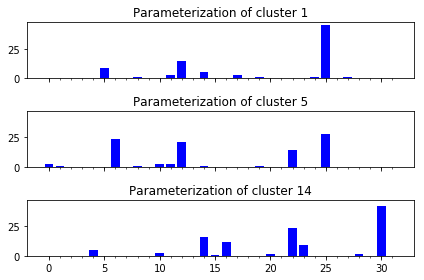

In [10]:
cs = [1, 5, 14]

fig, ax = plt.subplots(len(cs), 1, sharex=True, sharey=True)
for ax_, c in zip(ax, cs):
    
    ax_.bar(range(32), height=dc.components_[c], color='b')
    ax_.set_title("Parameterization of cluster {}".format(c))
[ax[i].set_xticks(range(32), range(32)) for i in range(2)]
plt.tight_layout()
plt.show()

5 rows from the W matrix:


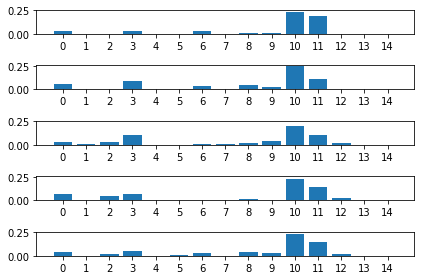

In [11]:
fig, ax = plt.subplots(5, 1, sharey=True)

for i, w in enumerate(W[10: 15]):
    ax[i].bar(range(len(w)), height=w)
    ax[i].set_xticks(range(len(w)))
print("5 rows from the W matrix:")
plt.tight_layout()
plt.show()    

In [12]:
sum_ = W.sum(axis=1)
print("The maximum and minimum sum in each row of the representation. Low values could be thought of as debris")
max(sum_), min(sum_)

The maximum and minimum sum in each row of the representation. Low values could be thought of as debris


(1.2087962888469872, 0.08716718996042308)

The next cell ranks the expression of all markers in each cluster. Also shows how many rows in W have the highest value for that cluster.

In [13]:
unique, counts = np.unique(labels, return_counts=True)
for C in range(14):
    print([markers[i] for i in dc.components_[C].argpartition(-4)[::-1]], counts[C], end='\n\n')

['CD44', 'CD45', 'CD235ab', 'CD47', 'CD45RA', 'CD4', 'CD22', 'CD14', 'CD38', 'CD3', 'CD16', 'CD15', 'CD7', 'CD11c', 'CD61', 'CD33', 'CD133', 'CD321', 'CD123', 'CD117', 'CD49d', 'CXCR4', 'CD20', 'Flt3', 'CD34', 'CD8', 'HLA-DR', 'CD11b', 'CD64', 'CD19', 'CD41', 'CD13'] 26550

['CD3', 'CD45', 'CD4', 'CD321', 'CD47', 'CD235ab', 'CD15', 'CD13', 'CD117', 'Flt3', 'CD133', 'CD7', 'CD61', 'CD14', 'CD11b', 'CD20', 'CD22', 'CD19', 'CXCR4', 'CD34', 'CD8', 'CD45RA', 'CD33', 'CD11c', 'CD16', 'CD44', 'CD38', 'CD49d', 'HLA-DR', 'CD64', 'CD41', 'CD123'] 51331

['CD11b', 'CD11c', 'CD13', 'CD33', 'CD45', 'CD47', 'CD44', 'CD14', 'CD34', 'CD61', 'CD123', 'CD20', 'CXCR4', 'CD4', 'CD22', 'CD19', 'CD133', 'CD321', 'Flt3', 'CD8', 'CD235ab', 'CD45RA', 'CD15', 'CD16', 'CD38', 'CD3', 'CD117', 'CD49d', 'HLA-DR', 'CD64', 'CD41', 'CD7'] 28949

['CD45', 'CD19', 'CD38', 'CD13', 'CD47', 'CD16', 'CD8', 'CD11b', 'CD49d', 'CD44', 'CD235ab', 'CD15', 'CD34', 'Flt3', 'CD22', 'CD33', 'CD20', 'CXCR4', 'CD14', 'CD4', 'CD45RA', 

In [14]:
import pandas as pd
from pandas import DataFrame as DF
from math import ceil
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
def walking_sum(of):
    "Need this so that the dataset can be split and coloured by clusters."
    from_to = [0 for _ in of]
    temp = [0 for _ in of]
    for i, val in enumerate(of):
        temp[i] = val + temp[i-1]
        from_to[i] = temp[i-1], temp[i]
        
    return from_to

def random_subset(df=df, label_name='label', desired_length=10000, seed=42):
    """Randomly chooses a subset of the data from each label and
    keeps a record of the indexes."""

    np.random.seed(seed)
    p_to_keep = desired_length / len(df)
    temp = []; sizes = []
    for i in np.unique(df[label_name].values):
        group = df[df[label_name] == i]
        length = group.shape[0]
        random_indexes = np.random.choice(range(0, length),
                                          size=ceil(length * p_to_keep))
        # group.iloc[random_indexes] -> a subset  of the dataset
        subgroup = group.iloc[random_indexes]
        temp.append(subgroup)
        sizes.append(subgroup.shape[0])
    df2 = pd.concat(temp)
    indexes = walking_sum(sizes)
    return df2, indexes

def make_colored_plot(nd_ar, indexes, start=0):
    """
    start=1 to skip the first cluster"""
    np.random.seed(42)
    if start != 0: np.random.rand(1, 3) # keeps colors consistent
    plt.clf()
    for s, e in indexes[start:]:
        plt.scatter(nd_ar[s:e, 0], nd_ar[s:e, 1],
                    c=np.random.rand(1,3), alpha=0.3)

    else:
        plt.show()
    
tsne = TSNE(n_components=2, verbose=1, perplexity=50, 
            n_iter=300, n_iter_without_progress=100, method="barnes_hut")
df.fillna(value=-1, inplace=True)


In [15]:
from sklearn.manifold import TSNE
df2, indexes = random_subset(label_name='nmf', df=df)
transformed_markers = tsne.fit_transform(df2[markers].values)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10008 samples in 0.046s...
[t-SNE] Computed neighbors for 10008 samples in 10.471s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10008
[t-SNE] Computed conditional probabilities for sample 2000 / 10008
[t-SNE] Computed conditional probabilities for sample 3000 / 10008
[t-SNE] Computed conditional probabilities for sample 4000 / 10008
[t-SNE] Computed conditional probabilities for sample 5000 / 10008
[t-SNE] Computed conditional probabilities for sample 6000 / 10008
[t-SNE] Computed conditional probabilities for sample 7000 / 10008
[t-SNE] Computed conditional probabilities for sample 8000 / 10008
[t-SNE] Computed conditional probabilities for sample 9000 / 10008
[t-SNE] Computed conditional probabilities for sample 10000 / 10008
[t-SNE] Computed conditional probabilities for sample 10008 / 10008
[t-SNE] Mean sigma: 0.949267
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.892937
[t-SNE] E

t-SNE plots are useful visualisations that show the structure of the data in just 2 dimensions.
If the clusters in the plot have different colors then they are more likely to be real, at least computationally.

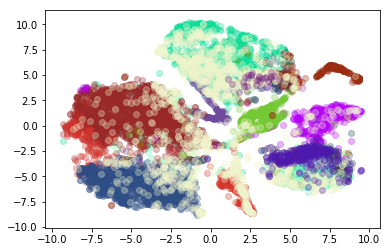

In [16]:
make_colored_plot(nd_ar=transformed_markers, indexes=indexes, start=0)

In [15]:
"The final error of the model", dc.reconstruction_err_

('The final error of the model', 871.2593327592548)

Reconstruction error is the Frobenius norm of the matrix given by V - WH.
The frobenius norm for matrix A is: sum(diagional(dot(A, A.T))).
The frobenius norm is related to the mean squared error:
https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm

The next cell plots each component, 
This highlights the need for some regularization. 

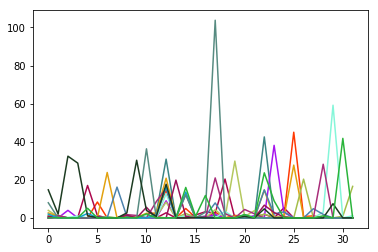

In [16]:
for i in range(15):
    plt.plot(dc.components_[i], c=np.random.rand(3))
plt.show()